# Q-learning model with neural networks

The idea is very similar to the one depicted in lab_week8 but rather than using RBF we will use a bunch of networks.

## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np

import virl
import utils

## Simulation

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from collections import namedtuple
from scipy.special import softmax

import itertools

env = virl.Epidemic(stochastic=False, noisy=False)

GLOBAL_SEED = 42

In [4]:
def create_policy(func_approximator, epsilon, num_actions):
    """
    Create a greedy policy with the exploration defined by the epsilon and nA parameters
    
    args:
    - func_approximator: a function approximator that gives the probability Q(s, a) for a given state s
    - epsilon: the probability to select a random action (float between 0 and 1).
        If 0, the algorithm is perfectly deterministic.
    - num_actions: the number of actions
    
    return: A policy function. Policy functions take a state as input and return an action to perform.
    """
    
    def policy_fn(state):
        """
        Perform an action.
        
        Returns: a pair (A, q_values) where `A` is a list of scores for each action and
        q_values is the actual value returned by the approximator. For low values of epsilon,
        the 'best' action will be reinforced at A[best_action].
        """
        A = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = func_approximator.predict(state)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A, q_values
    
    return policy_fn
    
class FunctionApproximator:
    """
    Approximate Q(s, a) with a neural network
    """
    
    def __init__(self, hidden_layer_sizes=(100,), eta0=0.0001, optimizer="adam", learning_rate="constant"):
        """
        Set up the function approximator.
        
        args:
        - hidden_layer_sizes: the number of neurons in each layer.
        - eta0: (initial) learning rate.
        - optimizer: optimizer to use. Can be "adam", "rmsprop", "sgd" etc.
        - learning_rate: if the optimizer is sgd, then the learning rate will
            decrease over time. See sklearn.neural_network.MLPRegressor for details
        """
        
        self.eta0 = eta0
        self.optimizer = optimizer
        
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        
        self.models = []
        for i in range(env.action_space.n):
            model = Pipeline([
                #("scaler", StandardScaler().fit(observation_examples)),
                ("log", FunctionTransformer(lambda s: np.log10(np.array(s) + 1))),
                ("neural_network", MLPRegressor(solver=optimizer, alpha=eta0, random_state=GLOBAL_SEED))
            ])
            
            # In order to perform training we need to perform active inference in the model.
            # However, sklearn does not let us do it before it is fitted.
            # Thus, use a partial_fit
            model.named_steps['neural_network'].partial_fit([env.reset()], [0])
            self.models.append(model)
        
    def predict(self, s, a = None):
        """
        Perform a prediction according to the approximation of Q(s, a)
        
        Args:
        - s: state to make predictions from extracted from the state space.
        - a: (Optional) action to make a prediction for.
        
        Return:
        - if a is not provided a list of scores of each action
        - if a is provided only the specific score of that action.
        """
        
        if a == None:
            return np.array([m.predict([s])[0] for m in self.models])
        else:
            return self.models[a].predict([s])[0]
    
    def update(self, s, a, y):
        """
        Update the model's parameters for a given state and action towards the target
        """
        self.models[a].named_steps['neural_network'].partial_fit([s], [y])

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

def q_learning(env, func_approximator, num_episodes, discount_factor=1.0,
               epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algo for Q-learning using a generic function approximation.
    """

    np.random.seed(GLOBAL_SEED)
    
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    for i_episode in range(num_episodes):
        # Create a handle to the policy we're following
        # The basic idea is that in the first episodes random operations are allowed but then more and more
        # discouraged as the function approximator improves.
        policy = create_policy(func_approximator, epsilon * epsilon_decay ** i_episode, env.action_space.n )

        last_reward = stats.episode_rewards[i_episode - 1]

        state = env.reset()

        for t in itertools.count():
            # probe the policy and sample an action
            action_probs, q_vals = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            # Perform the action
            next_state, reward, done, _ = env.step(action)

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Apply the Q-learning update equation
            q_values_next = func_approximator.predict(next_state)

            q_values_current = func_approximator.predict(state)

            td_target = reward + discount_factor * np.max(q_vals)

            func_approximator.update(state, action, td_target)
            
            #print("\rStep {} @ Episode {}/{} ({})               " \
            #      .format(t, i_episode + 1, num_episodes, last_reward), end="")
        
            
            if done:
                break

            state = next_state
        print("\rEpisode {} ({})".format(i_episode+1, last_reward), end="")

    print("")
    return stats

In [5]:
def evaluate(env, policy, full_eval=False, verbose=True, noisy=False):
    trained_policy = create_policy(approximator_dl, 0, 4)
    limit = 10 if full_eval else 1
        
    envs = [virl.Epidemic(problem_id=i, noisy=noisy) for i in range(limit)]
    
    fig, axes = plt.subplots(limit, 2, figsize=(20, 8*limit))
    
    total_rewards = []
    
    for i, env in enumerate(envs):
        states, rewards, action_taken = utils.execute_policy(trained_policy, env)
        if verbose:
            print(i, action_taken)
        # small hack to change the first key from i to 0
        if limit == 1:
            axes_wrapper = [axes[0], axes[1]]
        else:
            axes_wrapper = axes[i]
        utils.plot(states, rewards, action_taken, axes=axes_wrapper)
        total_rewards.append(sum(rewards))
    
    if limit > 1:
        _, ax = plt.subplots(1, 1, figsize=(10, 4))
        ax.bar(np.arange(limit), total_rewards)
        ax.set_xticks(np.arange(limit))

Episode 100 (-1.6336942500717835)
0 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
total reward -1.6336942500717837


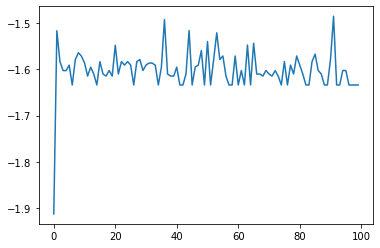

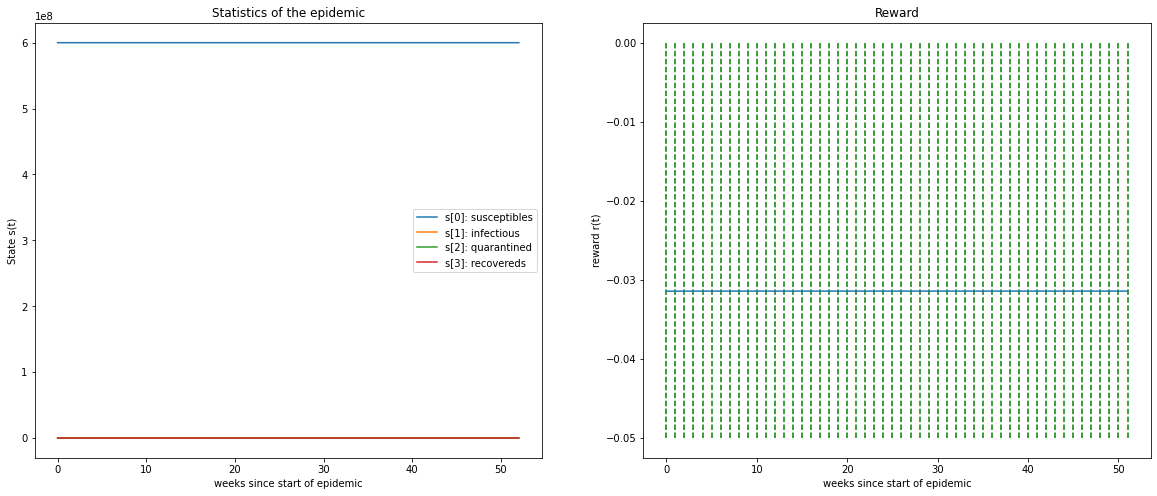

In [6]:
approximator_dl = FunctionApproximator(hidden_layer_sizes=(4,), eta0=0.02)
stats = q_learning(env, approximator_dl, 100, epsilon=0.05, epsilon_decay=.995, discount_factor=1)
plt.plot(stats.episode_rewards)
evaluate(env, approximator_dl)

Episode 100 (-0.9840671527869443)
0 [1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2]
total reward -0.9768414923970146


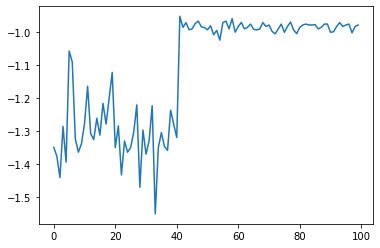

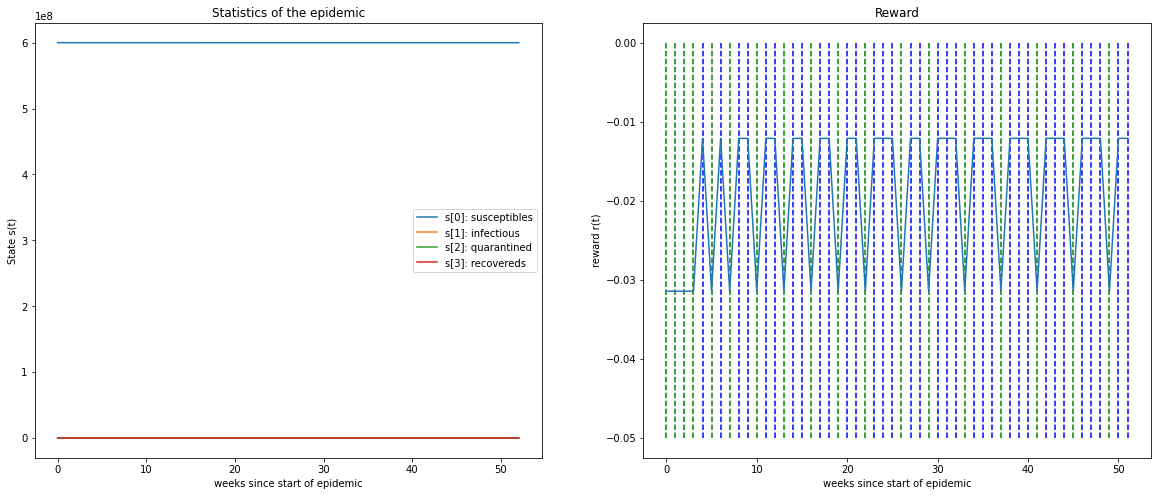

In [7]:
approximator_dl = FunctionApproximator(hidden_layer_sizes=(4,), eta0=0.02)
stats = q_learning(env, approximator_dl, 100, epsilon=0.1, epsilon_decay=.999, discount_factor=1)
plt.plot(stats.episode_rewards)
evaluate(env, approximator_dl)

Episode 100 (-0.9647569251330231)
0 [1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2]
total reward -0.9575291684367393


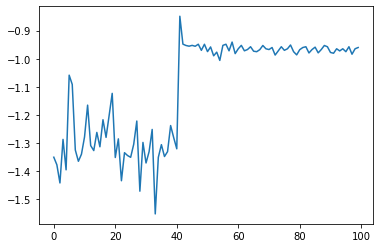

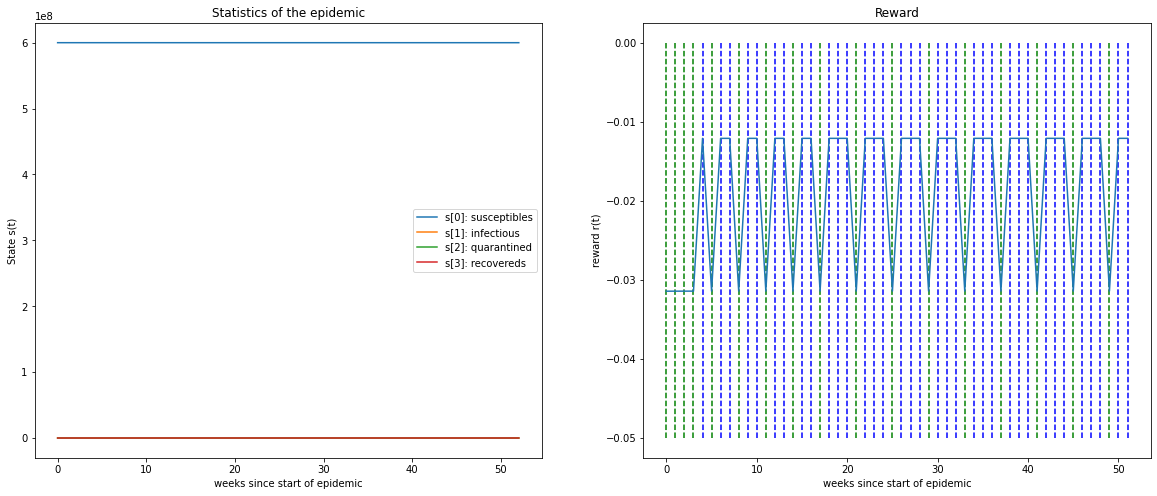

In [8]:
approximator_dl = FunctionApproximator(hidden_layer_sizes=(4,), eta0=0.02)
stats = q_learning(env, approximator_dl, 100, epsilon=0.1, epsilon_decay=1, discount_factor=1)
plt.plot(stats.episode_rewards)
evaluate(env, approximator_dl)

Episode 100 (-0.9411381890093635)
0 [3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2]
total reward -0.9338857403021653


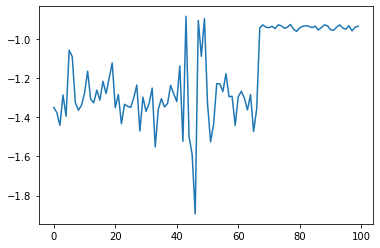

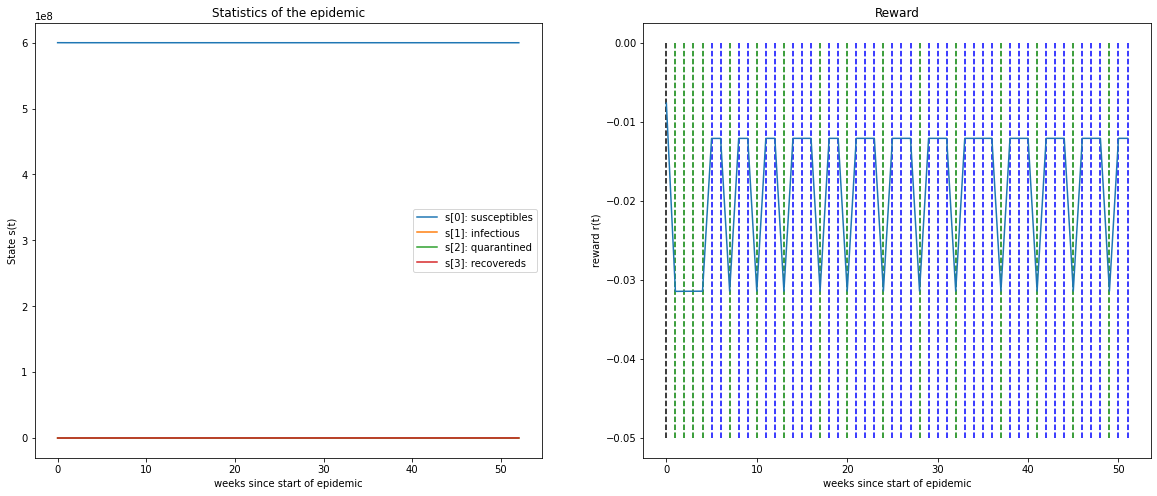

In [9]:
approximator_dl = FunctionApproximator(hidden_layer_sizes=(4,), eta0=0.05)
stats = q_learning(env, approximator_dl, 100, epsilon=0.1, epsilon_decay=1, discount_factor=.70)
plt.plot(stats.episode_rewards)
evaluate(env, approximator_dl)

## Analysis

total reward -0.9338857403021653
total reward -0.6826118991366482
total reward -0.70194667929197
total reward -0.7213142599145853
total reward -0.8372564660771645
total reward -1.0305287767028621
total reward -1.0885287200581708
total reward -1.1272352964523504
total reward -1.1659055774931333
total reward -1.2046421064179453


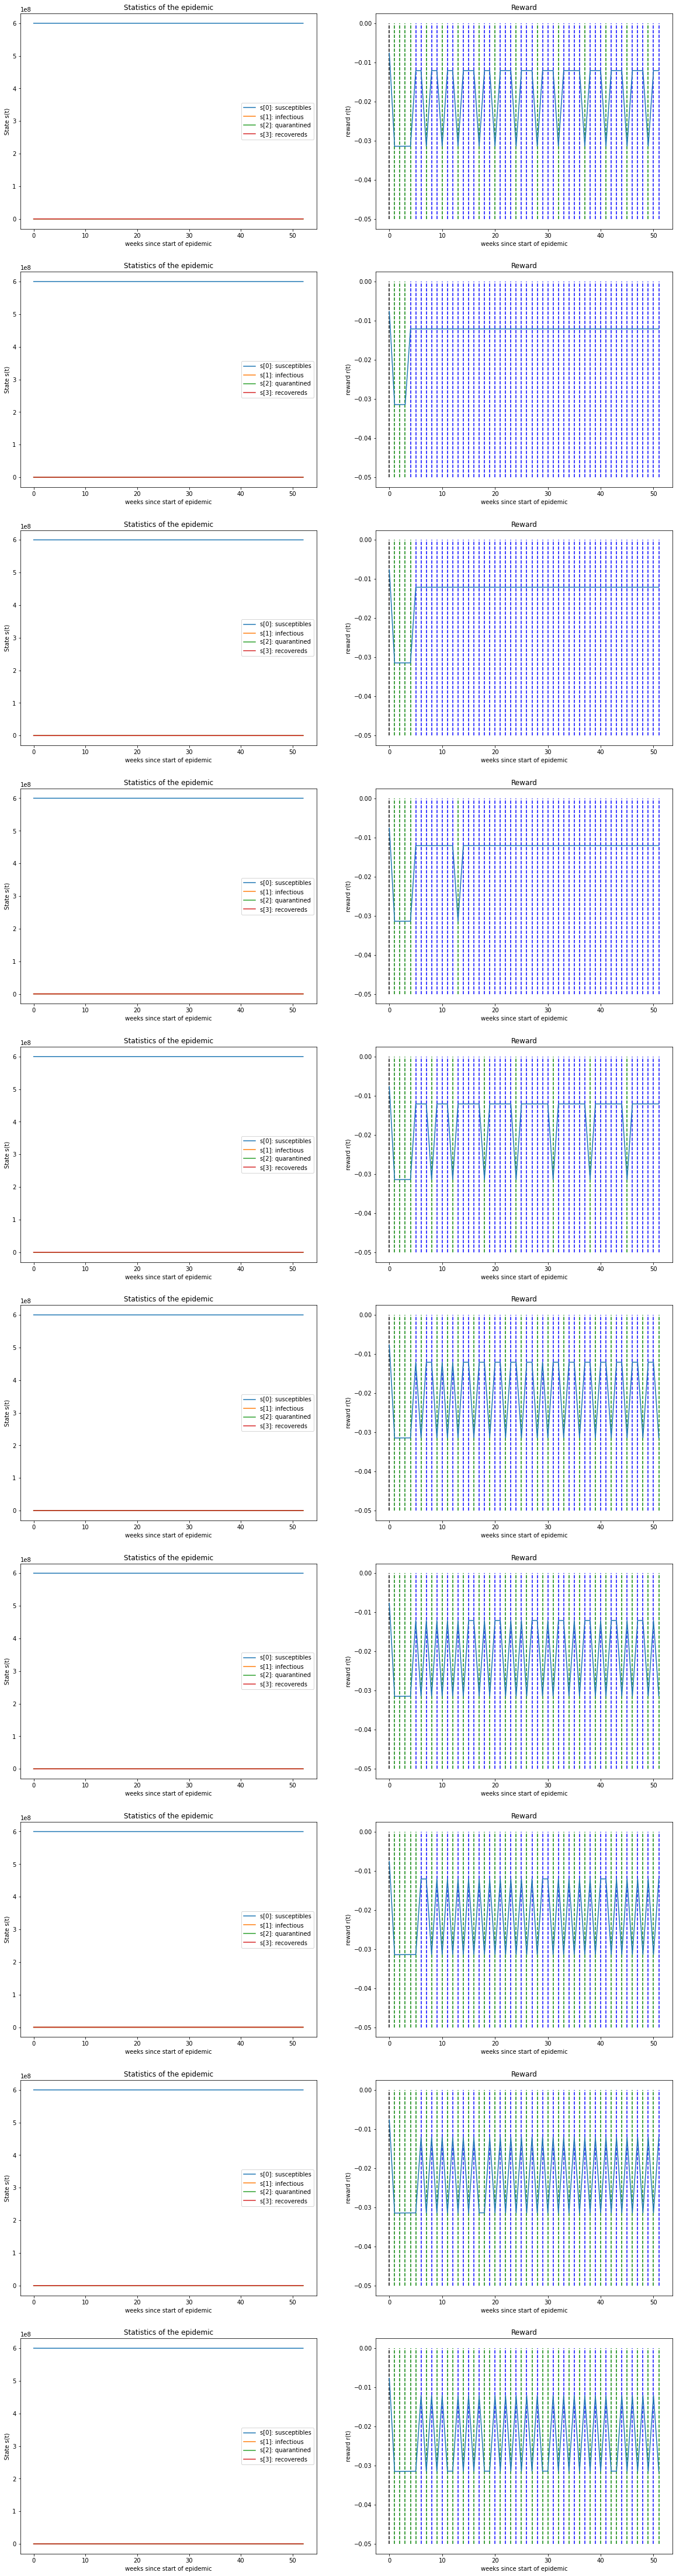

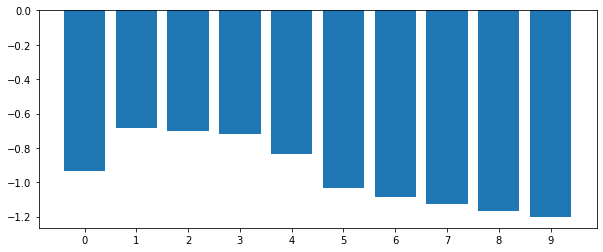

In [10]:
evaluate(env, approximator_dl, full_eval=True, verbose=False)

total reward -0.9338869538138115
total reward -0.6826118991366482
total reward -0.70194667929197
total reward -0.7213132370184714
total reward -0.8372536430214307
total reward -1.0305287767028621
total reward -1.088530966925752
total reward -1.1272327998732254
total reward -1.1659055774931333
total reward -1.2046470907764804


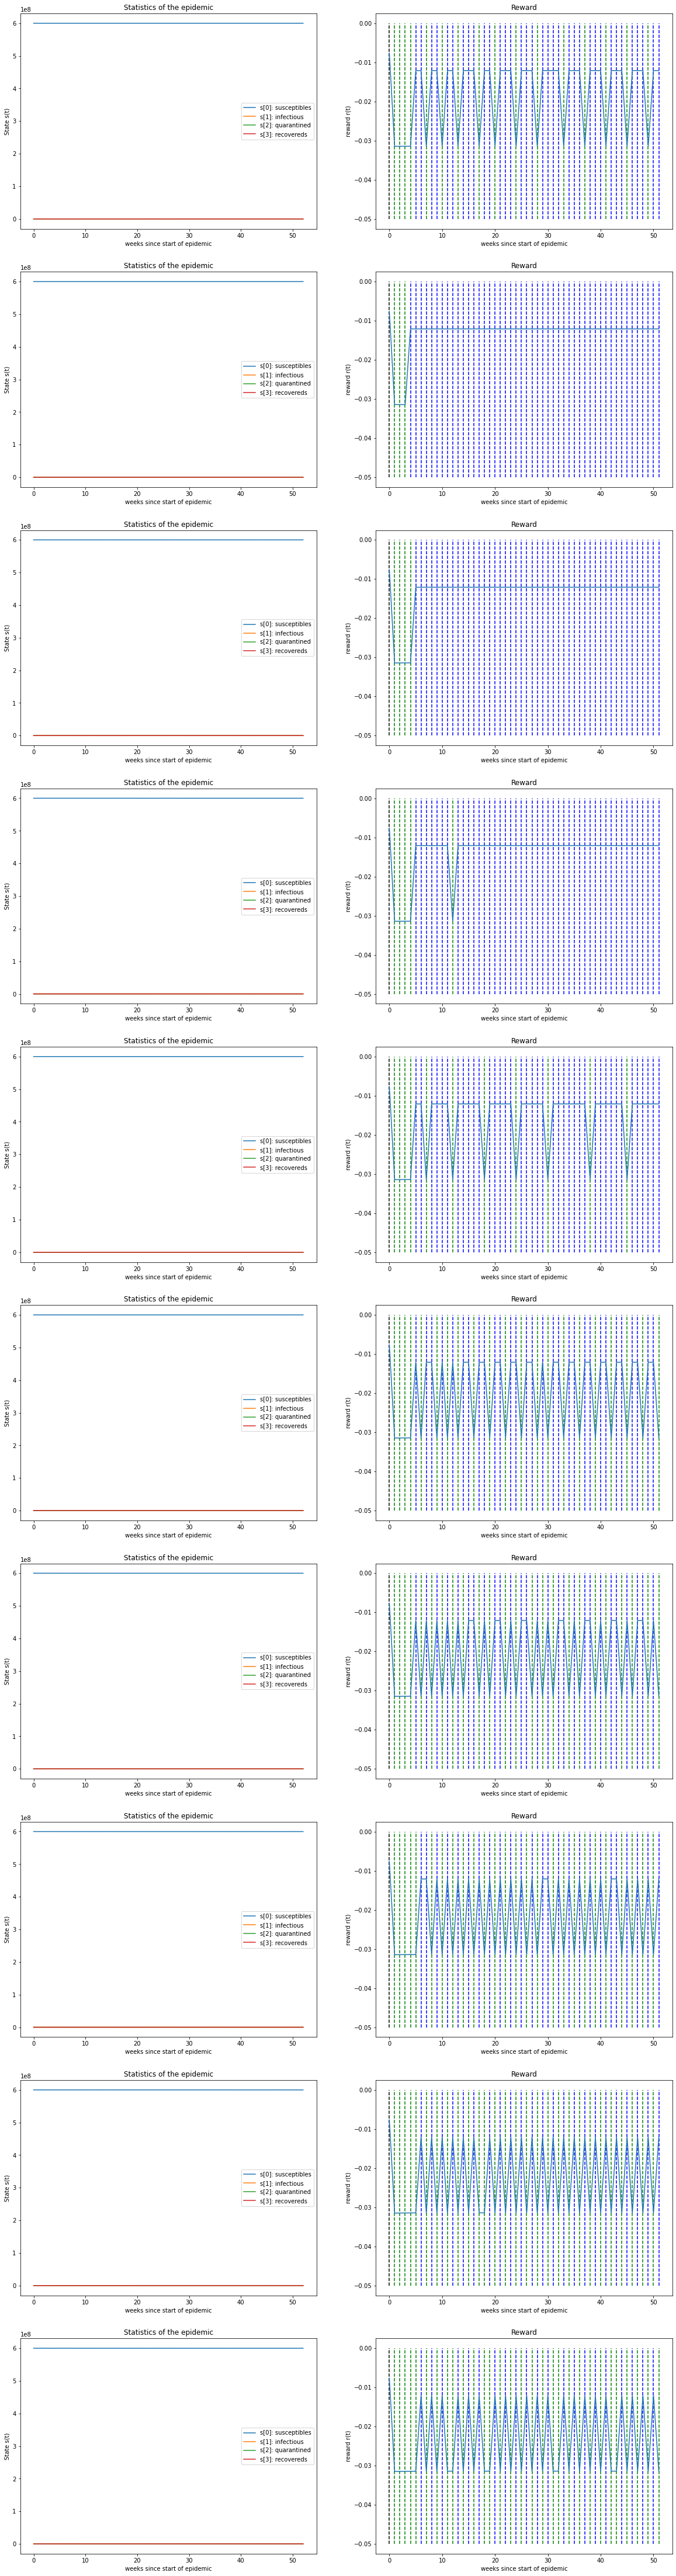

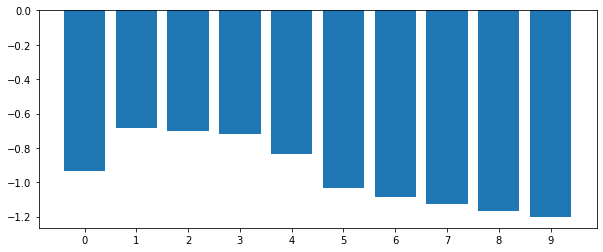

In [11]:
evaluate(env, approximator_dl, full_eval=True, verbose=False, noisy=True)

total reward -0.9338855096560864
total reward -0.6826118991366482
total reward -0.70194667929197
total reward -0.7213132370184714
total reward -0.8372572749944901
total reward -1.0305287767028621
total reward -1.0885259043174216
total reward -1.1272383330198261
total reward -1.1659055774931333
total reward -1.2046421064179453


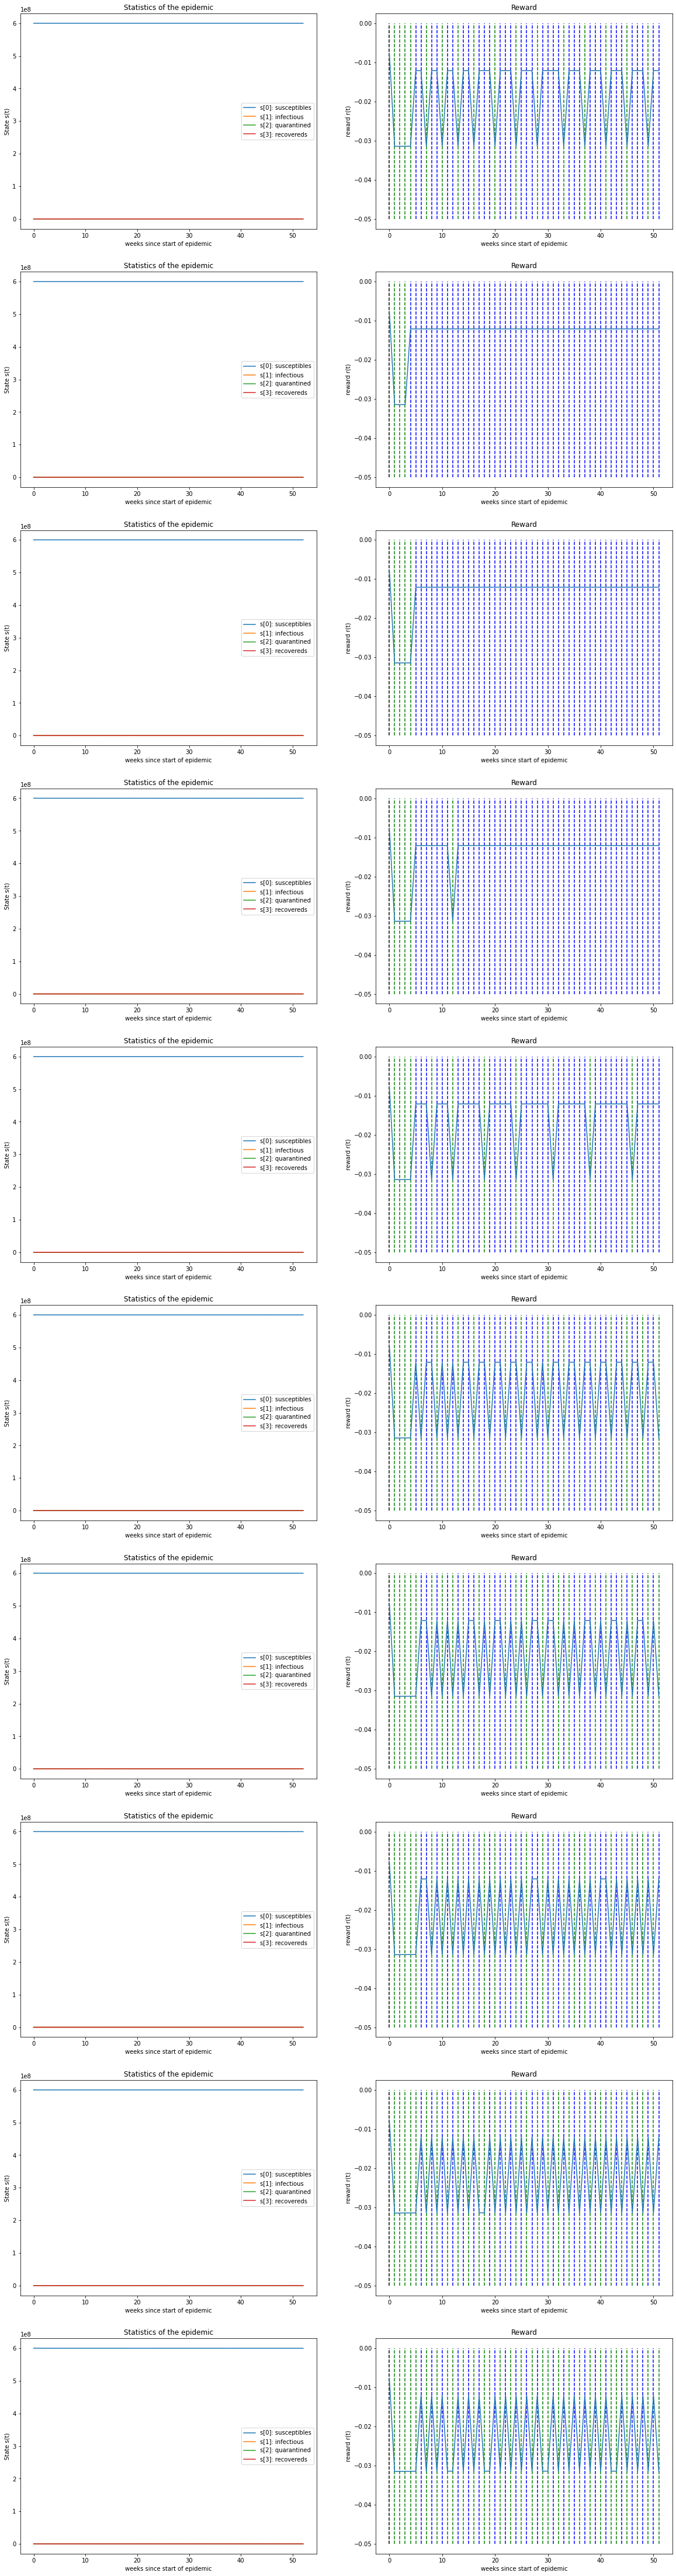

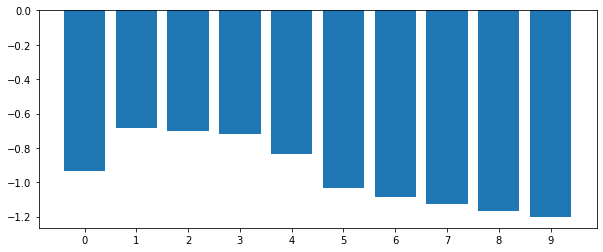

In [12]:
evaluate(env, approximator_dl, full_eval=True, verbose=False, noisy=True)